In [1]:
# Import tensorflow and additional libraries
import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd # this module is useful to work with tabular data
import random # this module will be used to select random samples from a collection
import os # this module will be used just to create directories in the local filesystem
from tqdm import tqdm # this module is useful to plot progress bars
import plotly.io as pio
#pio.renderers.default = 'colab'

import torch
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader,random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import plotly.express as px
from torch.nn.parameter import Parameter

#matplotlib error
os.environ['KMP_DUPLICATE_LIB_OK']='True'

# Check version
print('torch version: ', torch.__version__)

torch version:  1.10.1


C:\ProgramData\Anaconda3\envs\spare\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: Could not find module 'C:\ProgramData\Anaconda3\envs\spare\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


In [2]:
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')

print('Using PyTorch version:', torch.__version__, ' Device:', DEVICE)

Using PyTorch version: 1.10.1  Device: cuda


In [3]:
data_dir = './data'
### With these commands the train and test datasets, respectively, are downloaded
### automatically and stored in the local "data_dir" directory.
train_dataset = torchvision.datasets.FashionMNIST(data_dir, train=True, download=True)
test_dataset = torchvision.datasets.FashionMNIST(data_dir, train=False, download=True)

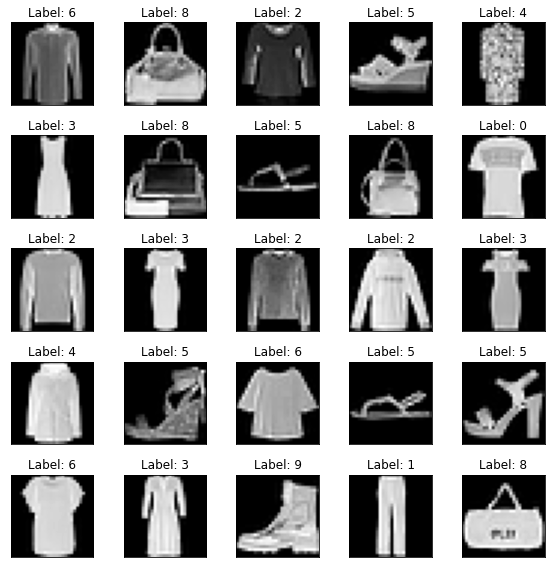

In [4]:
fig, axs = plt.subplots(5, 5, figsize=(8, 8))
for ax in axs.flatten():
    # random.choice allows to randomly sample from a list-like object (basically anything that can be accessed with an index, like our dataset)
    img, label = random.choice(train_dataset)
    ax.imshow(np.array(img), cmap='gist_gray')
    ax.set_title('Label: %d' % label)
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()

In [5]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
])

# Set the train transform
train_dataset.transform = train_transform
# Set the test transform
test_dataset.transform = test_transform

In [6]:
m = len(train_dataset)

# random_split randomly split a dataset into non-overlapping new datasets of given lengths
# train (55,000 images), val split (5,000 images)
train_data, val_data = random_split(train_dataset, [int(m-m*0.2), int(m*0.2)])

BATCH_SIZE = 16
EPOCHS = 30

# The dataloaders handle shuffling, batching, etc...
train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [7]:
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([16, 1, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([16]) type: torch.LongTensor


In [8]:
class channel_attention(nn.Module):    
    def __init__(self, channel, reduction = 4):
        super(channel_attention, self).__init__()
        
        self.avg_pool = nn.AdaptiveAvgPool2d(1)                    # Global Average Pooling (GAP)
        self.fc = nn.Sequential(                                   #
            nn.Linear(channel, channel // reduction, bias=False),  # fc1
            nn.ReLU(inplace=True),                                 # ReLU
            nn.Linear(channel // reduction, channel, bias=False),  # fc2
            nn.Sigmoid()                                           # Sigmoid
        )
        
    def forward(self, x): 
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        
        return x * y.expand_as(x)                                  # Fout = CA(Fin)

class spatial_attention(nn.Module):   
    def __init__(self, channel):
        super(spatial_attention, self).__init__()
        self.conv = nn.Conv2d(channel, 1, kernel_size=3, padding='same', bias=False)
        self.sigmoid = nn.Sigmoid()
            
    def forward(self, x):
        y = self.conv(x)
        y = self.sigmoid(y)
    
        return x * y.expand_as(x)
    
class parallel_add_attention(nn.Module):
    def __init__(self, channel, reduction):
        super(parallel_add_attention, self).__init__()
        self.CA = channel_attention(channel, reduction)
        self.SA = spatial_attention(channel)
    
    def forward(self, x):
        x1 = self.CA(x)
        x2 = self.SA(x)
        
        return x1 + x2
#         out = x1 + x2
        
#         return x * out.expand_as(x)
    
class parallel_mul_attention(nn.Module):
    def __init__(self, channel, reduction):
        super(parallel_mul_attention, self).__init__()
        self.CA = channel_attention(channel, reduction)
        self.SA = spatial_attention(channel)
    
    def forward(self, x):
        x1 = self.CA(x)
        x2 = self.SA(x)
        
        return torch.mul(x1,x2)
#         out = x1 * x2
        
#         return x * out.expand_as(x)

class serial_CASA_attention(nn.Module):
    def __init__(self, channel, reduction):
        super(serial_CASA_attention, self).__init__()
        self.CA = channel_attention(channel, reduction)
        self.SA = spatial_attention(channel)
    
    def forward(self, x):
        y = self.CA(x)
        y = self.SA(y)
        
        return x * y.expand_as(x)

class serial_SACA_attention(nn.Module):
    def __init__(self, channel, reduction):
        super(serial_SACA_attention, self).__init__()
        self.CA = channel_attention(channel, reduction)
        self.SA = spatial_attention(channel)
    
    def forward(self, x):
        y = self.SA(x)
        y = self.CA(y)
        
        return x * y.expand_as(x)
    
class attention_module(nn.Module):
    def __init__(self, channel, attention_type, reduction = 4):
        super(attention_module, self).__init__()
        self.channel = channel
        self.attention_type = attention_type
        self.reduction = reduction
        
        if self.attention_type == 'channel':
            # Channel Attnetion only
            self.attention_layer = channel_attention(self.channel, self.reduction)
            
        elif self.attention_type == 'spatial':
            # Spatial Attention only
            self.attention_layer = spatial_attention(self.channel)
            
        elif self.attention_type == 'parallel_add':
            # Parelle Attention (Add)
            self.attention_layer = parallel_add_attention(self.channel, self.reduction)

        elif self.attention_type == 'parallel_mul':
            # Parelle Attention (Mul)
            self.attention_layer = parallel_mul_attention(self.channel, self.reduction)

        elif self.attention_type == 'serial_ca':
            # Serial Attention, CA first
            self.attention_layer = serial_CASA_attention(self.channel, self.reduction)

        elif self.attention_type == 'serial_sa':
            # Serial Attention, SA first
            self.attention_layer = serial_SACA_attention(self.channel, self.reduction)

        else:
            self.attention_layer = None
            
    def forward(self, x):
        if self.attention_layer != None:
            return self.attention_layer(x)
        else:
            return x

In [9]:
#반복적으로 이용하는 block 정의
class res_block(nn.Module): #nn.Module 상속받아 정의
    def __init__(self, input_channels, output_channels, stride, attention_type, reduction): #input_channels는 input으로 이용되는 데이터의 채널 수, output_channels는 필터의 갯수
        super(res_block, self).__init__() #nn.Module의 메서드를 상속받습니다.
        self.stride = stride
        self.attention_type = attention_type
        self.reduction = reduction
        
        self.input_layer = nn.Sequential(
            nn.Conv2d(input_channels, output_channels, kernel_size = 1, stride = stride),
            nn.BatchNorm2d(output_channels) #input의 분포가 달라짐에 따라 학습속도가 느려지는 것을 막기 위해 사용
        )
        
        self.res_layer = nn.Sequential(
            nn.Conv2d(input_channels, output_channels, kernel_size = 1, stride = stride),
            nn.BatchNorm2d(output_channels),
            nn.ReLU(inplace = True),
            nn.Conv2d(output_channels, output_channels, kernel_size = 1, stride = 1, padding = 'same'), #위에서 통과한 결과값 사용
            nn.BatchNorm2d(output_channels)
        )
        
        self.relu = nn.ReLU()
        self.attention = attention_module(output_channels, self.attention_type, self.reduction)
    
    def forward(self, x): #계산과정
        residual = x
        
        if self.stride != 1:
            residual = self.input_layer(x)
        
        out = self.res_layer(x)
        out += residual
        out = self.relu(out)
        out = self.attention(out)
        
        return out

In [10]:
class normal_ResNet(nn.Module):
    def __init__(self, attention_type = None, num_classes = 10):
        super().__init__()
        self.resnet = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            res_block(input_channels=64, output_channels=64, stride=2, attention_type=None, reduction=None),
            res_block(input_channels=64, output_channels=64, stride=1, attention_type=None, reduction=None),
            res_block(input_channels=64, output_channels=128, stride=2, attention_type=None, reduction=None),
            res_block(input_channels=128, output_channels=128, stride=1, attention_type=None, reduction=None)
        )
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.linear = nn.Linear(128, num_classes)
        
    def forward(self, x):
        x = self.resnet(x)
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        
        return x

In [11]:
class channel_ResNet(nn.Module):
    def __init__(self, attention_type = 'channel', num_classes = 10):
        super().__init__()
        self.resnet = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            res_block(input_channels=64, output_channels=64, stride=2, attention_type='channel', reduction=4),
            res_block(input_channels=64, output_channels=64, stride=1, attention_type='channel', reduction=4),
            res_block(input_channels=64, output_channels=128, stride=2, attention_type='channel', reduction=4),
            res_block(input_channels=128, output_channels=128, stride=1, attention_type='channel', reduction=4)
        )
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.linear = nn.Linear(128, num_classes)
        
    def forward(self, x):
        x = self.resnet(x)
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        
        return x

In [12]:
class spatial_ResNet(nn.Module):
    def __init__(self, attention_type = 'spatial', num_classes = 10):
        super().__init__()
        self.resnet = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            res_block(input_channels=64, output_channels=64, stride=2, attention_type='spatial', reduction=4),
            res_block(input_channels=64, output_channels=64, stride=1, attention_type='spatial', reduction=4),
            res_block(input_channels=64, output_channels=128, stride=2, attention_type='spatial', reduction=4),
            res_block(input_channels=128, output_channels=128, stride=1, attention_type='spatial', reduction=4)
        )
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.linear = nn.Linear(128, num_classes)
        
    def forward(self, x):
        x = self.resnet(x)
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        
        return x

In [13]:
class parallel_add_ResNet(nn.Module):
    def __init__(self, attention_type = 'parellel_add', num_classes = 10):
        super().__init__()
        self.resnet = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            res_block(input_channels=64, output_channels=64, stride=2, attention_type='parallel_add', reduction=4),
            res_block(input_channels=64, output_channels=64, stride=1, attention_type='parallel_add', reduction=4),
            res_block(input_channels=64, output_channels=128, stride=2, attention_type='parallel_add', reduction=4),
            res_block(input_channels=128, output_channels=128, stride=1, attention_type='parallel_add', reduction=4)
        )
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.linear = nn.Linear(128, num_classes)
        
    def forward(self, x):
        x = self.resnet(x)
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        
        return x

In [14]:
class parallel_mul_ResNet(nn.Module):
    def __init__(self, attention_type = 'parellel_mul', num_classes = 10):
        super().__init__()
        self.resnet = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            res_block(input_channels=64, output_channels=64, stride=2, attention_type='parallel_mul', reduction=4),
            res_block(input_channels=64, output_channels=64, stride=1, attention_type='parallel_mul', reduction=4),
            res_block(input_channels=64, output_channels=128, stride=2, attention_type='parallel_mul', reduction=4),
            res_block(input_channels=128, output_channels=128, stride=1, attention_type='parallel_mul', reduction=4)
        )
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.linear = nn.Linear(128, num_classes)
        
    def forward(self, x):
        x = self.resnet(x)
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        
        return x

In [15]:
class serial_CASA_ResNet(nn.Module):
    def __init__(self, attention_type = 'serial_ca', num_classes = 10):
        super().__init__()
        self.resnet = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            res_block(input_channels=64, output_channels=64, stride=2, attention_type='serial_ca', reduction=4),
            res_block(input_channels=64, output_channels=64, stride=1, attention_type='serial_ca', reduction=4),
            res_block(input_channels=64, output_channels=128, stride=2, attention_type='serial_ca', reduction=4),
            res_block(input_channels=128, output_channels=128, stride=1, attention_type='serial_ca', reduction=4)
        )
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.linear = nn.Linear(128, num_classes)
        
    def forward(self, x):
        x = self.resnet(x)
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        
        return x

In [16]:
class serial_SACA_ResNet(nn.Module):
    def __init__(self, attention_type = 'serial_sa', num_classes = 10):
        super().__init__()
        self.resnet = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            res_block(input_channels=64, output_channels=64, stride=2, attention_type='serial_sa', reduction=4),
            res_block(input_channels=64, output_channels=64, stride=1, attention_type='serial_sa', reduction=4),
            res_block(input_channels=64, output_channels=128, stride=2, attention_type='serial_sa', reduction=4),
            res_block(input_channels=128, output_channels=128, stride=1, attention_type='serial_sa', reduction=4)
        )
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.linear = nn.Linear(128, num_classes)
        
    def forward(self, x):
        x = self.resnet(x)
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        
        return x

In [17]:
import torchsummary

torch.manual_seed(0)

model1 = normal_ResNet().to(DEVICE)
model2 = channel_ResNet().to(DEVICE)
model3 = spatial_ResNet().to(DEVICE)
model4 = parallel_add_ResNet().to(DEVICE)
model5 = parallel_mul_ResNet().to(DEVICE)
model6 = serial_CASA_ResNet().to(DEVICE)
model7 = serial_SACA_ResNet().to(DEVICE)

torchsummary.summary(model1, (1,28,28), device = 'cuda')
torchsummary.summary(model2, (1,28,28), device = 'cuda')
torchsummary.summary(model3, (1,28,28), device = 'cuda')
torchsummary.summary(model4, (1,28,28), device = 'cuda')
torchsummary.summary(model5, (1,28,28), device = 'cuda')
torchsummary.summary(model6, (1,28,28), device = 'cuda')
torchsummary.summary(model7, (1,28,28), device = 'cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 14, 14]           3,200
              ReLU-2           [-1, 64, 14, 14]               0
       BatchNorm2d-3           [-1, 64, 14, 14]             128
         MaxPool2d-4             [-1, 64, 7, 7]               0
            Conv2d-5             [-1, 64, 4, 4]           4,160
       BatchNorm2d-6             [-1, 64, 4, 4]             128
            Conv2d-7             [-1, 64, 4, 4]           4,160
       BatchNorm2d-8             [-1, 64, 4, 4]             128
              ReLU-9             [-1, 64, 4, 4]               0
           Conv2d-10             [-1, 64, 4, 4]           4,160
      BatchNorm2d-11             [-1, 64, 4, 4]             128
             ReLU-12             [-1, 64, 4, 4]               0
 attention_module-13             [-1, 64, 4, 4]               0
        res_block-14             [-1, 6

## Model Training

In [18]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model1.parameters(), lr=1e-3)

model1_train_loss = []
model1_val_loss = []
model1_val_accuracy = []

for epoch in range(EPOCHS+1):
    model1.train()
    train_total_loss = 0.0
    train_correct = 0

    for images, labels in train_loader:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        outputs = model1(images)
        predicted = torch.max(outputs, 1)[1]
        loss = criterion(outputs, labels)

        train_total_loss += loss.item()
        train_correct += (labels == predicted).sum().cpu()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model1.eval()
    val_total_loss = 0.0
    val_correct = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            outputs = model1(images)
            predicted = torch.max(outputs, 1)[1]
            loss = criterion(outputs, labels)

            val_total_loss += loss.item()
            val_correct += (labels == predicted).sum().cpu()

    train_loss = train_total_loss / len(train_loader.dataset)
    train_accuracy = train_correct / len(train_loader.dataset)
    val_loss = val_total_loss / len(test_loader.dataset)
    val_accuracy = val_correct / len(test_loader.dataset)

    print(
        f"epoch {epoch+1}:\t",
        f"train_loss: {train_loss:.4f},",
        f"train_accuracy: {train_accuracy:.4f},",
        f"val_loss: {val_loss:.4f},",
        f"val_accuracy: {val_accuracy:.4f}",
    )
    model1_train_loss.append(train_loss)
    model1_val_loss.append(val_loss)
    model1_val_accuracy.append(val_accuracy)

epoch 1:	 train_loss: 0.0382, train_accuracy: 0.7829, val_loss: 0.0337, val_accuracy: 0.8018
epoch 2:	 train_loss: 0.0305, train_accuracy: 0.8213, val_loss: 0.0311, val_accuracy: 0.8154
epoch 3:	 train_loss: 0.0277, train_accuracy: 0.8379, val_loss: 0.0287, val_accuracy: 0.8313
epoch 4:	 train_loss: 0.0264, train_accuracy: 0.8434, val_loss: 0.0287, val_accuracy: 0.8320
epoch 5:	 train_loss: 0.0250, train_accuracy: 0.8510, val_loss: 0.0283, val_accuracy: 0.8369
epoch 6:	 train_loss: 0.0242, train_accuracy: 0.8565, val_loss: 0.0283, val_accuracy: 0.8391
epoch 7:	 train_loss: 0.0231, train_accuracy: 0.8627, val_loss: 0.0270, val_accuracy: 0.8407
epoch 8:	 train_loss: 0.0225, train_accuracy: 0.8655, val_loss: 0.0265, val_accuracy: 0.8418
epoch 9:	 train_loss: 0.0219, train_accuracy: 0.8681, val_loss: 0.0261, val_accuracy: 0.8471
epoch 10:	 train_loss: 0.0213, train_accuracy: 0.8730, val_loss: 0.0280, val_accuracy: 0.8374
epoch 11:	 train_loss: 0.0209, train_accuracy: 0.8740, val_loss: 0.03

In [19]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=1e-3)

model2_train_loss = []
model2_val_loss = []
model2_val_accuracy = []

for epoch in range(EPOCHS+1):
    model2.train()
    train_total_loss = 0.0
    train_correct = 0

    for images, labels in train_loader:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        outputs = model2(images)
        predicted = torch.max(outputs, 1)[1]
        loss = criterion(outputs, labels)

        train_total_loss += loss.item()
        train_correct += (labels == predicted).sum().cpu()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model2.eval()
    val_total_loss = 0.0
    val_correct = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            outputs = model2(images)
            predicted = torch.max(outputs, 1)[1]
            loss = criterion(outputs, labels)

            val_total_loss += loss.item()
            val_correct += (labels == predicted).sum().cpu()

    train_loss = train_total_loss / len(train_loader.dataset)
    train_accuracy = train_correct / len(train_loader.dataset)
    val_loss = val_total_loss / len(test_loader.dataset)
    val_accuracy = val_correct / len(test_loader.dataset)

    print(
        f"epoch {epoch+1}:\t",
        f"train_loss: {train_loss:.4f},",
        f"train_accuracy: {train_accuracy:.4f},",
        f"val_loss: {val_loss:.4f},",
        f"val_accuracy: {val_accuracy:.4f}",
    )
    model2_train_loss.append(train_loss)
    model2_val_loss.append(val_loss)
    model2_val_accuracy.append(val_accuracy)

epoch 1:	 train_loss: 0.0371, train_accuracy: 0.7881, val_loss: 0.0306, val_accuracy: 0.8243
epoch 2:	 train_loss: 0.0267, train_accuracy: 0.8424, val_loss: 0.0252, val_accuracy: 0.8497
epoch 3:	 train_loss: 0.0239, train_accuracy: 0.8595, val_loss: 0.0241, val_accuracy: 0.8547
epoch 4:	 train_loss: 0.0220, train_accuracy: 0.8696, val_loss: 0.0232, val_accuracy: 0.8617
epoch 5:	 train_loss: 0.0205, train_accuracy: 0.8792, val_loss: 0.0212, val_accuracy: 0.8770
epoch 6:	 train_loss: 0.0194, train_accuracy: 0.8841, val_loss: 0.0220, val_accuracy: 0.8715
epoch 7:	 train_loss: 0.0186, train_accuracy: 0.8903, val_loss: 0.0205, val_accuracy: 0.8814
epoch 8:	 train_loss: 0.0178, train_accuracy: 0.8936, val_loss: 0.0227, val_accuracy: 0.8674
epoch 9:	 train_loss: 0.0171, train_accuracy: 0.8968, val_loss: 0.0201, val_accuracy: 0.8846
epoch 10:	 train_loss: 0.0165, train_accuracy: 0.9000, val_loss: 0.0215, val_accuracy: 0.8764
epoch 11:	 train_loss: 0.0160, train_accuracy: 0.9039, val_loss: 0.02

In [20]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model3.parameters(), lr=1e-3)

model3_train_loss = []
model3_val_loss = []
model3_val_accuracy = []

for epoch in range(EPOCHS+1):
    model3.train()
    train_total_loss = 0.0
    train_correct = 0

    for images, labels in train_loader:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        outputs = model3(images)
        predicted = torch.max(outputs, 1)[1]
        loss = criterion(outputs, labels)

        train_total_loss += loss.item()
        train_correct += (labels == predicted).sum().cpu()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model3.eval()
    val_total_loss = 0.0
    val_correct = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            outputs = model3(images)
            predicted = torch.max(outputs, 1)[1]
            loss = criterion(outputs, labels)

            val_total_loss += loss.item()
            val_correct += (labels == predicted).sum().cpu()

    train_loss = train_total_loss / len(train_loader.dataset)
    train_accuracy = train_correct / len(train_loader.dataset)
    val_loss = val_total_loss / len(test_loader.dataset)
    val_accuracy = val_correct / len(test_loader.dataset)

    print(
        f"epoch {epoch+1}:\t",
        f"train_loss: {train_loss:.4f},",
        f"train_accuracy: {train_accuracy:.4f},",
        f"val_loss: {val_loss:.4f},",
        f"val_accuracy: {val_accuracy:.4f}",
    )
    model3_train_loss.append(train_loss)
    model3_val_loss.append(val_loss)
    model3_val_accuracy.append(val_accuracy)

epoch 1:	 train_loss: 0.0348, train_accuracy: 0.8003, val_loss: 0.0269, val_accuracy: 0.8465
epoch 2:	 train_loss: 0.0257, train_accuracy: 0.8497, val_loss: 0.0260, val_accuracy: 0.8481
epoch 3:	 train_loss: 0.0230, train_accuracy: 0.8658, val_loss: 0.0243, val_accuracy: 0.8565
epoch 4:	 train_loss: 0.0213, train_accuracy: 0.8756, val_loss: 0.0258, val_accuracy: 0.8492
epoch 5:	 train_loss: 0.0200, train_accuracy: 0.8812, val_loss: 0.0211, val_accuracy: 0.8778
epoch 6:	 train_loss: 0.0189, train_accuracy: 0.8890, val_loss: 0.0208, val_accuracy: 0.8772
epoch 7:	 train_loss: 0.0180, train_accuracy: 0.8938, val_loss: 0.0228, val_accuracy: 0.8615
epoch 8:	 train_loss: 0.0175, train_accuracy: 0.8972, val_loss: 0.0201, val_accuracy: 0.8856
epoch 9:	 train_loss: 0.0168, train_accuracy: 0.9001, val_loss: 0.0211, val_accuracy: 0.8794
epoch 10:	 train_loss: 0.0162, train_accuracy: 0.9044, val_loss: 0.0195, val_accuracy: 0.8894
epoch 11:	 train_loss: 0.0156, train_accuracy: 0.9073, val_loss: 0.02

In [21]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model4.parameters(), lr=1e-3)

model4_train_loss = []
model4_val_loss = []
model4_val_accuracy = []

for epoch in range(EPOCHS+1):
    model4.train()
    train_total_loss = 0.0
    train_correct = 0

    for images, labels in train_loader:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        outputs = model4(images)
        predicted = torch.max(outputs, 1)[1]
        loss = criterion(outputs, labels)

        train_total_loss += loss.item()
        train_correct += (labels == predicted).sum().cpu()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model4.eval()
    val_total_loss = 0.0
    val_correct = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            outputs = model4(images)
            predicted = torch.max(outputs, 1)[1]
            loss = criterion(outputs, labels)

            val_total_loss += loss.item()
            val_correct += (labels == predicted).sum().cpu()

    train_loss = train_total_loss / len(train_loader.dataset)
    train_accuracy = train_correct / len(train_loader.dataset)
    val_loss = val_total_loss / len(test_loader.dataset)
    val_accuracy = val_correct / len(test_loader.dataset)

    print(
        f"epoch {epoch+1}:\t",
        f"train_loss: {train_loss:.4f},",
        f"train_accuracy: {train_accuracy:.4f},",
        f"val_loss: {val_loss:.4f},",
        f"val_accuracy: {val_accuracy:.4f}",
    )
    model4_train_loss.append(train_loss)
    model4_val_loss.append(val_loss)
    model4_val_accuracy.append(val_accuracy)

epoch 1:	 train_loss: 0.0341, train_accuracy: 0.8037, val_loss: 0.0271, val_accuracy: 0.8409
epoch 2:	 train_loss: 0.0251, train_accuracy: 0.8519, val_loss: 0.0253, val_accuracy: 0.8546
epoch 3:	 train_loss: 0.0223, train_accuracy: 0.8696, val_loss: 0.0227, val_accuracy: 0.8668
epoch 4:	 train_loss: 0.0204, train_accuracy: 0.8798, val_loss: 0.0217, val_accuracy: 0.8703
epoch 5:	 train_loss: 0.0192, train_accuracy: 0.8859, val_loss: 0.0226, val_accuracy: 0.8691
epoch 6:	 train_loss: 0.0182, train_accuracy: 0.8913, val_loss: 0.0217, val_accuracy: 0.8760
epoch 7:	 train_loss: 0.0173, train_accuracy: 0.8978, val_loss: 0.0216, val_accuracy: 0.8735
epoch 8:	 train_loss: 0.0168, train_accuracy: 0.8993, val_loss: 0.0195, val_accuracy: 0.8870
epoch 9:	 train_loss: 0.0161, train_accuracy: 0.9036, val_loss: 0.0210, val_accuracy: 0.8799
epoch 10:	 train_loss: 0.0155, train_accuracy: 0.9076, val_loss: 0.0200, val_accuracy: 0.8879
epoch 11:	 train_loss: 0.0150, train_accuracy: 0.9103, val_loss: 0.02

In [22]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model5.parameters(), lr=1e-3)

model5_train_loss = []
model5_val_loss = []
model5_val_accuracy = []

for epoch in range(EPOCHS+1):
    model5.train()
    train_total_loss = 0.0
    train_correct = 0

    for images, labels in train_loader:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        outputs = model5(images)
        predicted = torch.max(outputs, 1)[1]
        loss = criterion(outputs, labels)

        train_total_loss += loss.item()
        train_correct += (labels == predicted).sum().cpu()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model5.eval()
    val_total_loss = 0.0
    val_correct = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            outputs = model5(images)
            predicted = torch.max(outputs, 1)[1]
            loss = criterion(outputs, labels)

            val_total_loss += loss.item()
            val_correct += (labels == predicted).sum().cpu()

    train_loss = train_total_loss / len(train_loader.dataset)
    train_accuracy = train_correct / len(train_loader.dataset)
    val_loss = val_total_loss / len(test_loader.dataset)
    val_accuracy = val_correct / len(test_loader.dataset)

    print(
        f"epoch {epoch+1}:\t",
        f"train_loss: {train_loss:.4f},",
        f"train_accuracy: {train_accuracy:.4f},",
        f"val_loss: {val_loss:.4f},",
        f"val_accuracy: {val_accuracy:.4f}",
    )
    model5_train_loss.append(train_loss)
    model5_val_loss.append(val_loss)
    model5_val_accuracy.append(val_accuracy)

epoch 1:	 train_loss: 0.0420, train_accuracy: 0.7559, val_loss: 0.0333, val_accuracy: 0.8209
epoch 2:	 train_loss: 0.0285, train_accuracy: 0.8358, val_loss: 0.0282, val_accuracy: 0.8362
epoch 3:	 train_loss: 0.0252, train_accuracy: 0.8535, val_loss: 0.0261, val_accuracy: 0.8483
epoch 4:	 train_loss: 0.0232, train_accuracy: 0.8641, val_loss: 0.0247, val_accuracy: 0.8618
epoch 5:	 train_loss: 0.0215, train_accuracy: 0.8727, val_loss: 0.0220, val_accuracy: 0.8720
epoch 6:	 train_loss: 0.0204, train_accuracy: 0.8798, val_loss: 0.0227, val_accuracy: 0.8665
epoch 7:	 train_loss: 0.0195, train_accuracy: 0.8854, val_loss: 0.0226, val_accuracy: 0.8678
epoch 8:	 train_loss: 0.0185, train_accuracy: 0.8912, val_loss: 0.0211, val_accuracy: 0.8753
epoch 9:	 train_loss: 0.0180, train_accuracy: 0.8945, val_loss: 0.0219, val_accuracy: 0.8703
epoch 10:	 train_loss: 0.0175, train_accuracy: 0.8955, val_loss: 0.0218, val_accuracy: 0.8741
epoch 11:	 train_loss: 0.0170, train_accuracy: 0.8996, val_loss: 0.02

In [23]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model6.parameters(), lr=1e-3)

model6_train_loss = []
model6_val_loss = []
model6_val_accuracy = []

for epoch in range(EPOCHS+1):
    model6.train()
    train_total_loss = 0.0
    train_correct = 0

    for images, labels in train_loader:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        outputs = model6(images)
        predicted = torch.max(outputs, 1)[1]
        loss = criterion(outputs, labels)

        train_total_loss += loss.item()
        train_correct += (labels == predicted).sum().cpu()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model6.eval()
    val_total_loss = 0.0
    val_correct = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            outputs = model6(images)
            predicted = torch.max(outputs, 1)[1]
            loss = criterion(outputs, labels)

            val_total_loss += loss.item()
            val_correct += (labels == predicted).sum().cpu()

    train_loss = train_total_loss / len(train_loader.dataset)
    train_accuracy = train_correct / len(train_loader.dataset)
    val_loss = val_total_loss / len(test_loader.dataset)
    val_accuracy = val_correct / len(test_loader.dataset)

    print(
        f"epoch {epoch+1}:\t",
        f"train_loss: {train_loss:.4f},",
        f"train_accuracy: {train_accuracy:.4f},",
        f"val_loss: {val_loss:.4f},",
        f"val_accuracy: {val_accuracy:.4f}",
    )
    model6_train_loss.append(train_loss)
    model6_val_loss.append(val_loss)
    model6_val_accuracy.append(val_accuracy)

epoch 1:	 train_loss: 0.0435, train_accuracy: 0.7454, val_loss: 0.0295, val_accuracy: 0.8315
epoch 2:	 train_loss: 0.0268, train_accuracy: 0.8430, val_loss: 0.0249, val_accuracy: 0.8526
epoch 3:	 train_loss: 0.0236, train_accuracy: 0.8606, val_loss: 0.0250, val_accuracy: 0.8534
epoch 4:	 train_loss: 0.0219, train_accuracy: 0.8710, val_loss: 0.0239, val_accuracy: 0.8620
epoch 5:	 train_loss: 0.0206, train_accuracy: 0.8790, val_loss: 0.0215, val_accuracy: 0.8760
epoch 6:	 train_loss: 0.0194, train_accuracy: 0.8844, val_loss: 0.0213, val_accuracy: 0.8742
epoch 7:	 train_loss: 0.0186, train_accuracy: 0.8912, val_loss: 0.0217, val_accuracy: 0.8769
epoch 8:	 train_loss: 0.0177, train_accuracy: 0.8933, val_loss: 0.0202, val_accuracy: 0.8833
epoch 9:	 train_loss: 0.0171, train_accuracy: 0.8983, val_loss: 0.0208, val_accuracy: 0.8814
epoch 10:	 train_loss: 0.0165, train_accuracy: 0.9010, val_loss: 0.0191, val_accuracy: 0.8890
epoch 11:	 train_loss: 0.0160, train_accuracy: 0.9037, val_loss: 0.01

In [24]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model7.parameters(), lr=1e-3)

model7_train_loss = []
model7_val_loss = []
model7_val_accuracy = []

for epoch in range(EPOCHS+1):
    model7.train()
    train_total_loss = 0.0
    train_correct = 0

    for images, labels in train_loader:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        outputs = model7(images)
        predicted = torch.max(outputs, 1)[1]
        loss = criterion(outputs, labels)

        train_total_loss += loss.item()
        train_correct += (labels == predicted).sum().cpu()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model7.eval()
    val_total_loss = 0.0
    val_correct = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            outputs = model7(images)
            predicted = torch.max(outputs, 1)[1]
            loss = criterion(outputs, labels)

            val_total_loss += loss.item()
            val_correct += (labels == predicted).sum().cpu()

    train_loss = train_total_loss / len(train_loader.dataset)
    train_accuracy = train_correct / len(train_loader.dataset)
    val_loss = val_total_loss / len(test_loader.dataset)
    val_accuracy = val_correct / len(test_loader.dataset)

    print(
        f"epoch {epoch+1}:\t",
        f"train_loss: {train_loss:.4f},",
        f"train_accuracy: {train_accuracy:.4f},",
        f"val_loss: {val_loss:.4f},",
        f"val_accuracy: {val_accuracy:.4f}",
    )
    model7_train_loss.append(train_loss)
    model7_val_loss.append(val_loss)
    model7_val_accuracy.append(val_accuracy)

epoch 1:	 train_loss: 0.0446, train_accuracy: 0.7534, val_loss: 0.0292, val_accuracy: 0.8284
epoch 2:	 train_loss: 0.0287, train_accuracy: 0.8326, val_loss: 0.0297, val_accuracy: 0.8249
epoch 3:	 train_loss: 0.0253, train_accuracy: 0.8540, val_loss: 0.0273, val_accuracy: 0.8457
epoch 4:	 train_loss: 0.0231, train_accuracy: 0.8647, val_loss: 0.0255, val_accuracy: 0.8476
epoch 5:	 train_loss: 0.0217, train_accuracy: 0.8710, val_loss: 0.0232, val_accuracy: 0.8672
epoch 6:	 train_loss: 0.0204, train_accuracy: 0.8802, val_loss: 0.0236, val_accuracy: 0.8574
epoch 7:	 train_loss: 0.0192, train_accuracy: 0.8855, val_loss: 0.0207, val_accuracy: 0.8749
epoch 8:	 train_loss: 0.0187, train_accuracy: 0.8909, val_loss: 0.0204, val_accuracy: 0.8814
epoch 9:	 train_loss: 0.0179, train_accuracy: 0.8945, val_loss: 0.0206, val_accuracy: 0.8767
epoch 10:	 train_loss: 0.0174, train_accuracy: 0.8977, val_loss: 0.0203, val_accuracy: 0.8814
epoch 11:	 train_loss: 0.0168, train_accuracy: 0.9000, val_loss: 0.01

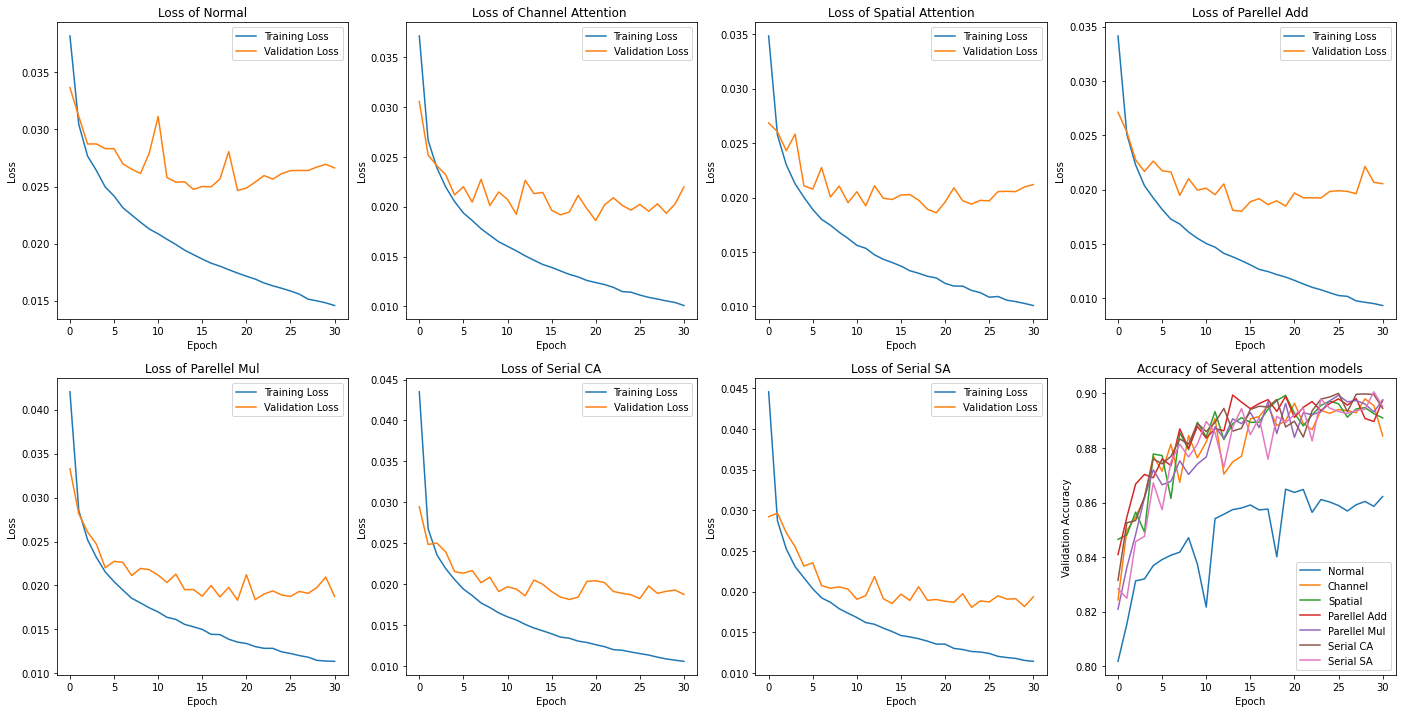

In [25]:
import matplotlib.pyplot as plt
plt.figure(figsize=(24,12))
plt.subplot(2,4,1)
plt.plot(np.arange(31), model1_train_loss)
plt.plot(np.arange(31), model1_val_loss)
plt.title('Loss of Normal')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc=0)

plt.subplot(2,4,2)
plt.plot(np.arange(31), model2_train_loss)
plt.plot(np.arange(31), model2_val_loss)
plt.title('Loss of Channel Attention ')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc=0)

plt.subplot(2,4,3)
plt.plot(np.arange(31), model3_train_loss)
plt.plot(np.arange(31), model3_val_loss)
plt.title('Loss of Spatial Attention')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc=0)

plt.subplot(2,4,4)
plt.plot(np.arange(31), model4_train_loss)
plt.plot(np.arange(31), model4_val_loss)
plt.title('Loss of Parellel Add')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc=0)

plt.subplot(2,4,5)
plt.plot(np.arange(31), model5_train_loss)
plt.plot(np.arange(31), model5_val_loss)
plt.title('Loss of Parellel Mul')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc=0)


plt.subplot(2,4,6)
plt.plot(np.arange(31), model6_train_loss)
plt.plot(np.arange(31), model6_val_loss)
plt.title('Loss of Serial CA')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc=0)


plt.subplot(2,4,7)
plt.plot(np.arange(31), model7_train_loss)
plt.plot(np.arange(31), model7_val_loss)
plt.title('Loss of Serial SA')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc=0)


plt.subplot(2,4,8)
plt.plot(model1_val_accuracy)
plt.plot(model2_val_accuracy)
plt.plot(model3_val_accuracy)
plt.plot(model4_val_accuracy)
plt.plot(model5_val_accuracy)
plt.plot(model6_val_accuracy)
plt.plot(model7_val_accuracy)

plt.title('Accuracy of Several attention models')
plt.ylabel('Validation Accuracy')
plt.xlabel('Epoch')
plt.legend(['Normal', 'Channel','Spatial','Parellel Add','Parellel Mul','Serial CA','Serial SA'], loc=0)
plt.savefig('result_resnet.jpg')
plt.show()
